<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

# Import Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

print(tf.__version__)

2.6.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and Explore Data

In [3]:
#load data and fill null values
train_df = pd.read_csv('/content/drive/MyDrive/Data Science/Datasets/Wikipedia_Toxic_Comments_Classification/train.csv').fillna(' ')

#see random comments
train_df.sample(10, random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [4]:
#define
X = train_df['comment_text'].values
print(X)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [5]:
#view few toxic comments
train_df.loc[train_df['toxic']==1].sample(10, random_state=10)

,comment_text,toxic
30575,"""\n Are you asking if we would ever block some...",1
36038,Amen my sock-pupinski brother!! Hack-a-long: p...,1
19730,JUST READ THE FUCKING CENSUS DATA. Do you thin...,1
72261,u no wat ass hole go fuck your self and stop b...,1
77923,Go fuck yourself \n\nEat shit and die. 68.0.11...,1
16382,A big thank you\n\nYou have just blocked me in...,1
41247,A message from Jasonceyre \n\n f uc k you ho...,1
69311,"I'm gonna get the ACLU on you, you racist anti...",1
142032,"Hey Freepsbane, does your mother know that you...",1
5613,You guys suk. You really really suck. Fuck you...,1


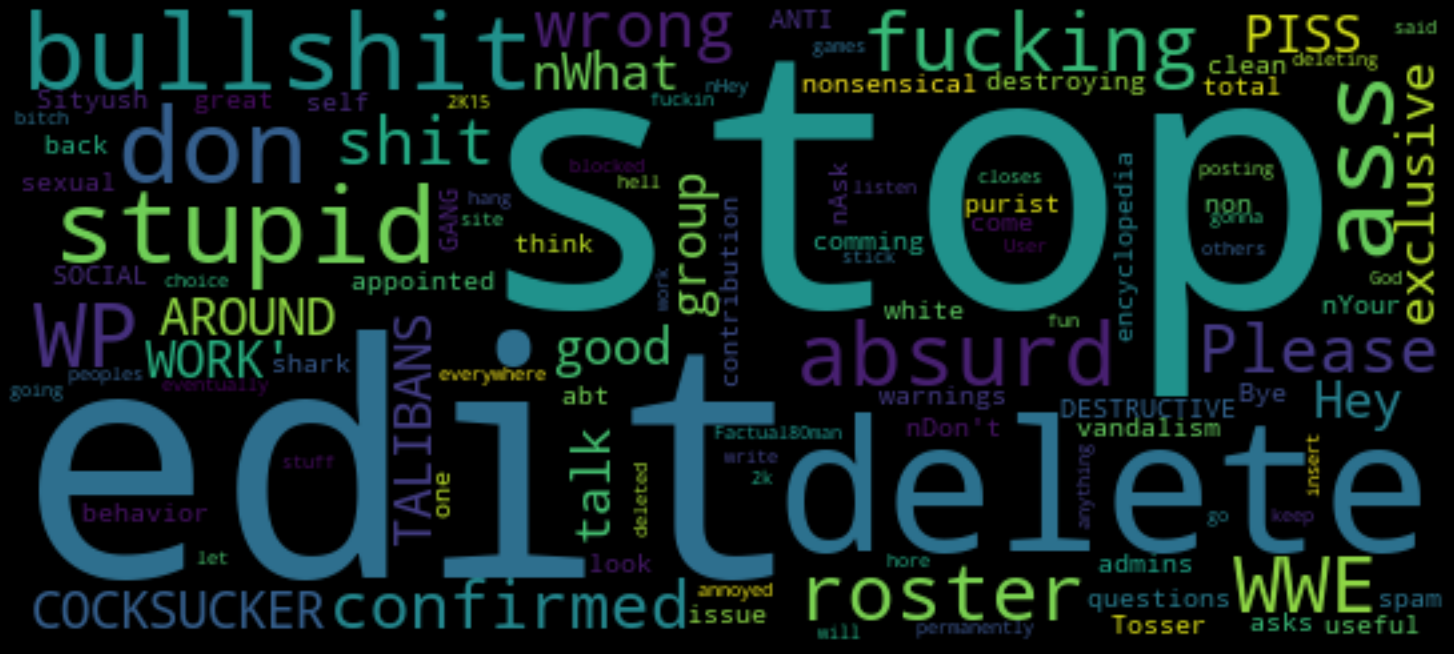

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#plot wordcloud
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 540,
    height = 240,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [7]:
#define y
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


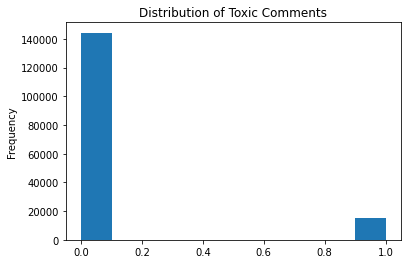

In [8]:
#plot frequency of toxic comments to see how many toxic vs. non-toxic comments
train_df['toxic'].plot(kind='hist',
                      title='Distribution of Toxic Comments')

In [9]:
#get counts
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

# Data Prep — Tokenize and Pad Text Data

In [10]:
#keep 20000 most common words
max_features = 20000

#set max length for each comment
maxlen = 400

In [11]:
#tokenizer object
tokenizer = text.Tokenizer(max_features)

#fit tokenizer onto text
tokenizer.fit_on_texts(list(X))

#convert text to number
X_train_seq = tokenizer.texts_to_sequences(X)

#pad each sequence so that each comment has the same length
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=maxlen)

# Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [12]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-08-27 23:56:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-27 23:56:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-27 23:56:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
#create dictionary to map the comments onto the embedding
#set embedding dimension
embedding_dim = 100
embeddings_index = dict()

#open file
f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

#close file
f.close()

#the number of word vectors that we've parsed
print(f'Found {len(embeddings_index)} word vector.')

Found 400000 word vector.


In [14]:
#check out our vocabulary
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [15]:
#create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))

#get the words and their embedding vectors and populate that into embedding matrix
for word, index in tokenizer.word_index.items():
    if index > max_features -1: #-1 because 0 index
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Create the Embedding Layer

In [16]:
#create model
model = Sequential()

#load embedding matrix
model.add(Embedding(max_features, 
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

#add Dropout
model.add(Dropout(0.2))

# Build Model

In [17]:
#hyperparameters
filters = 250
kernel_size = 3
hidden_dims = 250

In [18]:
#keep building model
model.add(Conv1D(filters,
                kernel_size,
                padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                5,
                padding='valid',
                activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims,
               activation='relu'))
model.add(Dropout(0.2))

#output
model.add(Dense(1,
               activation='sigmoid'))

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

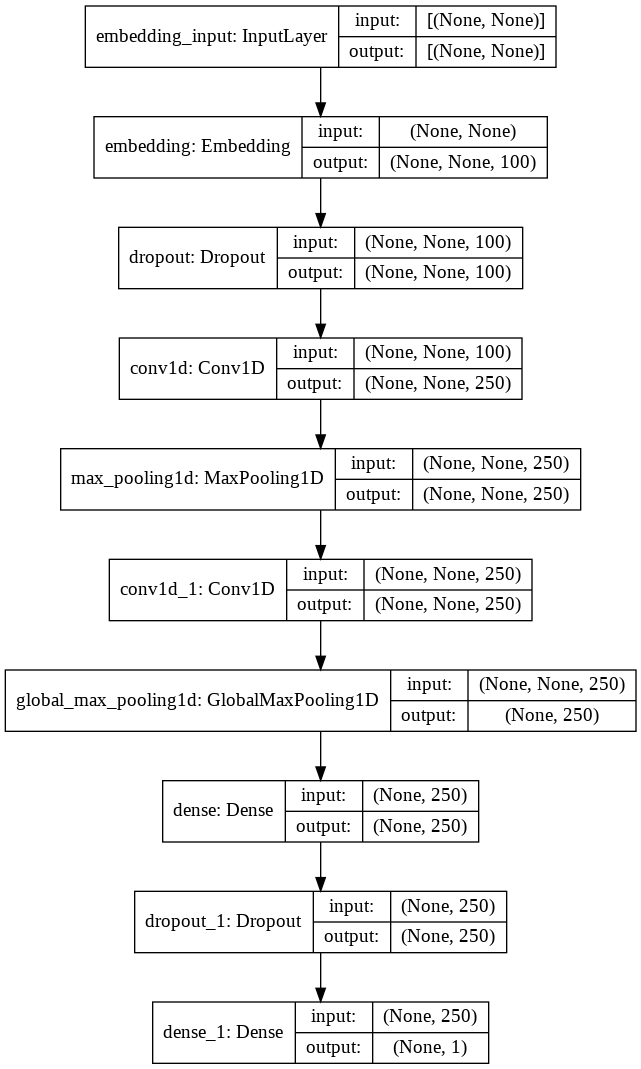

In [19]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

# Train Model

In [20]:
#train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y, test_size=0.25, random_state=121)

In [21]:
#compile
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

#add callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True)]

In [22]:
batch_size = 32
epochs = 20

#fit
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=early_stopping)

Epoch 1/20
3740/3740 [==============================] - 105s 20ms/step - loss: 0.1552 - accuracy: 0.9439 - val_loss: 0.1382 - val_accuracy: 0.9490
Epoch 2/20
3740/3740 [==============================] - 75s 20ms/step - loss: 0.1354 - accuracy: 0.9504 - val_loss: 0.1241 - val_accuracy: 0.9512
Epoch 3/20
3740/3740 [==============================] - 75s 20ms/step - loss: 0.1255 - accuracy: 0.9542 - val_loss: 0.1216 - val_accuracy: 0.9522
Epoch 4/20
3740/3740 [==============================] - 75s 20ms/step - loss: 0.1182 - accuracy: 0.9561 - val_loss: 0.1189 - val_accuracy: 0.9550
Epoch 5/20
3740/3740 [==============================] - 74s 20ms/step - loss: 0.1121 - accuracy: 0.9571 - val_loss: 0.1183 - val_accuracy: 0.9554
Epoch 6/20
3740/3740 [==============================] - 74s 20ms/step - loss: 0.1052 - accuracy: 0.9600 - val_loss: 0.1242 - val_accuracy: 0.9558
Epoch 7/20
3740/3740 [==============================] - 74s 20ms/step - loss: 0.0986 - accuracy: 0.9622 - val_loss: 0.1197 

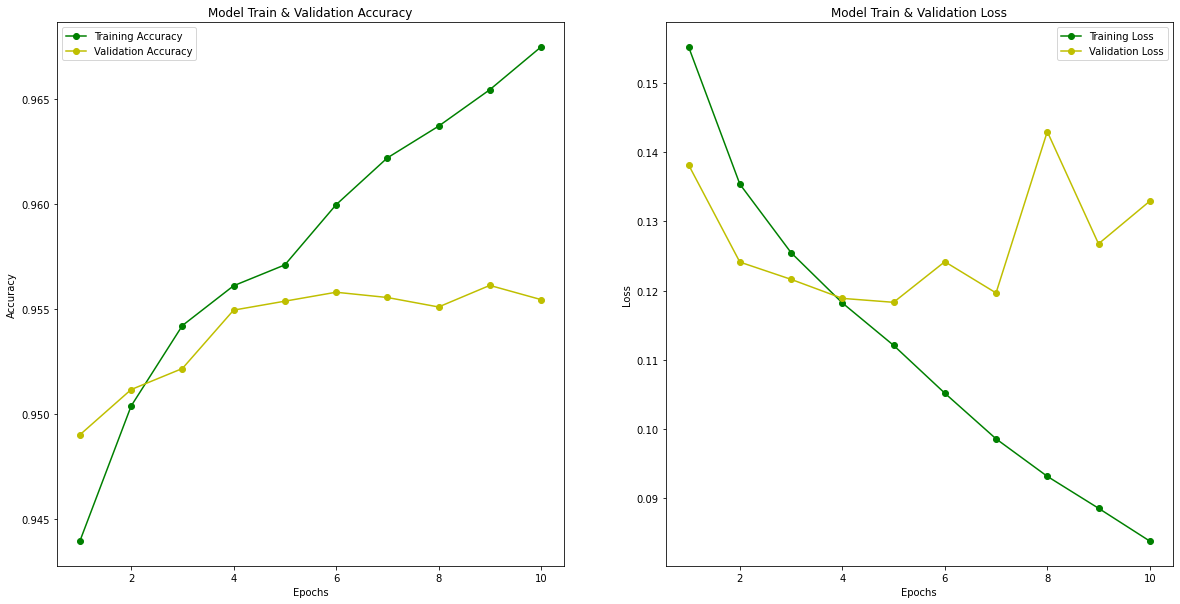

In [23]:
#plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

# Evaluate Model

In [24]:
#evaluate trained model
print('Train loss & accuracy:', model.evaluate(X_train, y_train))
print('\n')
print('Test loss & accuracy:', model.evaluate(X_val, y_val))

3740/3740 [==============================] - 28s 8ms/step - loss: 0.0482 - accuracy: 0.9807
Train loss & accuracy: [0.04822130128741264, 0.9806647896766663]


1247/1247 [==============================] - 10s 8ms/step - loss: 0.1329 - accuracy: 0.9555
Test loss & accuracy: [0.13293743133544922, 0.9554558396339417]


In [25]:
#make prediction using the validation set
preds = model.predict(X_val)

In [26]:
# if the predicted value is >0.5 it is toxic
prediction = []
for i in range(len(preds)):
    if preds[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [27]:
#accuracy score
accuracy_score(y_val, prediction)

0.9554558443837264

In [28]:
#get classification report
print(classification_report(y_val, prediction, target_names = ['not toxic (Class 0)','toxic (Class 1)']))

                     precision    recall  f1-score   support

not toxic (Class 0)       0.96      0.99      0.98     36110
    toxic (Class 1)       0.86      0.63      0.73      3783

           accuracy                           0.96     39893
          macro avg       0.91      0.81      0.85     39893
       weighted avg       0.95      0.96      0.95     39893



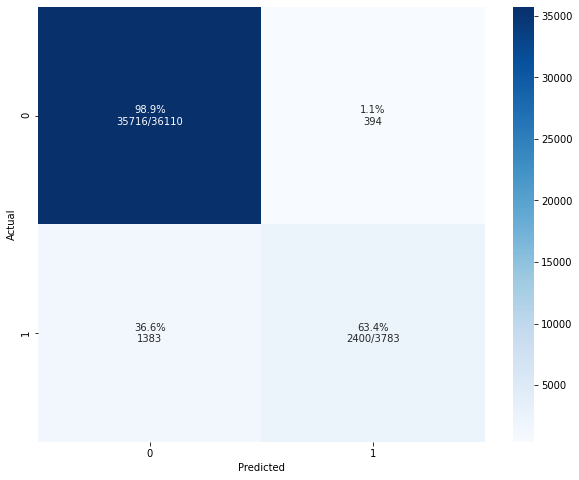

In [29]:
#plot confusion matrix function
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= plt.cm.Blues, annot=annot, fmt='', ax=ax)

#apply function    
plot_cm(y_val, prediction)

AUC: 0.9648495144326896


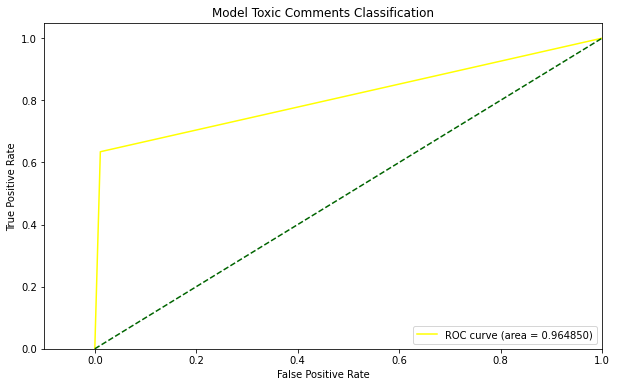

In [30]:
#roc curve
fpr, tpr, thresholds = roc_curve(y_val, prediction)
auc = roc_auc_score(y_val, preds)
print('AUC:', auc)

plt.figure(figsize = (10, 6))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Toxic Comments Classification')
plt.legend(loc = "lower right")
plt.show()

# Make Predictions with Test Set

In [31]:
#see test set
test_df = pd.read_csv('/content/drive/MyDrive/Data Science/Datasets/Wikipedia_Toxic_Comments_Classification/test.csv')
test_df.head()

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.


In [32]:
#define X_test
X_test = test_df['comment_text'].values

In [33]:
#tokenize
X_test_seq = tokenizer.texts_to_sequences(X_test)

#pad
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=maxlen)

In [34]:
#predict
yhat_test = model.predict(X_test_pad, verbose=1, batch_size=32)

4787/4787 [==============================] - 26s 5ms/step


In [35]:
#check shape
yhat_test.shape

(153164, 1)

In [36]:
#see prediction
yhat_test[0]

array([0.9980824], dtype=float32)

In [37]:
test_df['Toxic'] = ['not toxic' if x < .5 else 'toxic' for x in yhat_test]

#see predictions
test_df[['comment_text', 'Toxic']].sample(20)

,comment_text,Toxic
3978,"==gay== \n i like metal, but it's f***ing gay ...",toxic
43722,fags please comment here,not toxic
42237,You would like the details from the private in...,not toxic
87396,:This is a false positive. Every sane person k...,not toxic
123672,==Sock puppet== \n About this edit] I guess w...,not toxic
14650,""" \n\n ===Bonus Question=== \n\n You've given ...",not toxic
28347,My article got approved! Thanks so much for al...,not toxic
50774,":actually, nevermind, there is still one there...",not toxic
74732,""" \n\n RolandR, by """"cherry-picking from dubio...",not toxic
60340,== Hi == \n\n go fuck yourself you piece of sht,toxic
